# COVID-19 in Mexico

## Define the problem
COVID-19 is taking a big toll on the Mexican population. Currently having the 7th place worldwide. I decided to dive in and understand better the current situation in there.

The main question is: 

* Which factor has the biggest impact on deaths once infected with COVID-19?
* Is there a correlation between cases and death with days of the week?
* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

In [1]:
__author__ = "Erika Garces"
__email__ = "epgarces3@gmail.com"

In [2]:
# impory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from os import listdir
import geopandas as gpd
import datetime as dt
from datetime import date

from sklearn import preprocessing

sns.set_style("ticks")
%matplotlib inline

## About datasets

COVID-19 data was taken from Ministry of Health MX:  https://www.gob.mx/salud/documentos/datos-abiertos-152127

Mexico's Shape File was taken from ESRI: https://www.arcgis.com/home/item.html?id=ac9041c51b5c49c683fbfec61dc03ba8

Population data was taken from INEGI and PopulationPyramid.net: 
* https://www.inegi.org.mx/temas/estructura/
* https://www.populationpyramid.net/es/méxico/2020/

## Load the Data 

In [3]:
# Function to print all the files in a folder 
def file_folder (path):
    filepaths = [path + f for f in listdir(path)]
    print (filepaths)

In [4]:
path = "Data/"
covid_general = file_folder(path)

['Data/datos_abiertos_20200812.csv', 'Data/datos_abiertos_20200810.csv', 'Data/datos_abiertos_20200811.csv', 'Data/gender.csv', 'Data/.DS_Store', 'Data/Mexico-2020.csv', 'Data/mexstates.dbf', 'Data/Catalogos_0412.xlsx', 'Data/mexstates.shp', 'Data/mexstates.shx', 'Data/mexstates.sbx', 'Data/Poblacion_Edad.xlsx', 'Data/.keep', 'Data/200802COVID19MEXICO.csv', 'Data/clean_data.csv', 'Data/01_poblacion.xls', 'Data/.ipynb_checkpoints', 'Data/mexstates.prj', 'Data/mexstates.sbn', 'Data/mexstates.shp.xml', 'Data/Poblacion_Entidad.xlsx', 'Data/Descriptores_0419.xlsx']


In [5]:
# Loading shape file
geo_states = gpd.read_file(path + "mexstates.shp")

In [6]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"datos_abiertos_20200812.csv", encoding='latin-1')
df_general = df_genera_mx

In [7]:
#Population data
df_population = pd.read_excel(open(path + 'Poblacion_Entidad.xlsx', 'rb')) 
df_population.head()

,Num,Entidad,Total,Hombres,Mujeres
0,0.0,Estados Unidos Mexicanos,112336538.0,54855231.0,57481307.0
1,1.0,Aguascalientes,1184996.0,576638.0,608358.0
2,2.0,Baja California,3155070.0,1591610.0,1563460.0
3,3.0,Baja California Sur,637026.0,325433.0,311593.0
4,4.0,Campeche,822441.0,407721.0,414720.0


In [8]:
df_gender_pop = pd.read_csv(path + 'Mexico-2020.csv') 
df_gender_pop.head()

,Edad,M,F,Total
0,0-4,5604781,5353961,10958742
1,5-9,5731706,5478805,11210511
2,10-14,5692822,5448048,11140870
3,15-19,5695013,5514580,11209593
4,20-24,5505161,5434658,10939819


In [9]:
#COVID-19 file uses descriptors. The descriptors are analyzed below. 
df_descriptors = pd.read_excel(open(path + 'Descriptores_0419.xlsx', 'rb')) 
df_descriptors.head()

,Nº,NOMBRE DE VARIABLE,DESCRIPCIÓN DE VARIABLE,FORMATO O FUENTE
0,1,FECHA_ACTUALIZACION,"La base de datos se alimenta diariamente, esta...",AAAA-MM-DD
1,2,ID_REGISTRO,Número identificador del caso,TEXTO
2,3,ORIGEN,La vigilancia centinela se realiza a través de...,CATÁLOGO: ORIGEN ...
3,4,SECTOR,Identifica el tipo de institución del Sistema ...,CATÁLOGO: SECTOR ...
4,5,ENTIDAD_UM,Identifica la entidad donde se ubica la unidad...,CATALÓGO: ENTIDADES


In [10]:
df_states = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo de ENTIDADES') 
df_states.head()

,CLAVE_ENTIDAD,ENTIDAD_FEDERATIVA,ABREVIATURA
0,1,AGUASCALIENTES,AS
1,2,BAJA CALIFORNIA,BC
2,3,BAJA CALIFORNIA SUR,BS
3,4,CAMPECHE,CC
4,5,COAHUILA DE ZARAGOZA,CL


In [11]:
df_sector = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SECTOR') 
df_sector.head()

,CLAVE,DESCRIPCIÓN
0,1,CRUZ ROJA
1,2,DIF
2,3,ESTATAL
3,4,IMSS
4,5,IMSS-BIENESTAR


In [12]:
df_paciente = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo TIPO_PACIENTE') 
df_paciente

,CLAVE,DESCRIPCIÓN
0,1,AMBULATORIO
1,2,HOSPITALIZADO
2,99,NO ESPECIFICADO


In [13]:
df_gender = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SEXO') 
df_gender

,CLAVE,DESCRIPCIÓN
0,1,MUJER
1,2,HOMBRE
2,99,NO ESPECIFICADO


## Examine data

In [14]:
# checking the size of the file 
df_general.shape 

(1127115, 35)

In [15]:
# checking the data type of the columns
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127115 entries, 0 to 1127114
Data columns (total 35 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   FECHA_ACTUALIZACION  1127115 non-null  object
 1   ID_REGISTRO          1127115 non-null  object
 2   ORIGEN               1127115 non-null  int64 
 3   SECTOR               1127115 non-null  int64 
 4   ENTIDAD_UM           1127115 non-null  int64 
 5   SEXO                 1127115 non-null  int64 
 6   ENTIDAD_NAC          1127115 non-null  int64 
 7   ENTIDAD_RES          1127115 non-null  int64 
 8   MUNICIPIO_RES        1127115 non-null  int64 
 9   TIPO_PACIENTE        1127115 non-null  int64 
 10  FECHA_INGRESO        1127115 non-null  object
 11  FECHA_SINTOMAS       1127115 non-null  object
 12  FECHA_DEF            1127115 non-null  object
 13  INTUBADO             1127115 non-null  int64 
 14  NEUMONIA             1127115 non-null  int64 
 15  EDAD           

In [16]:
#checking the first 5 rows.
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-08-12,13f301,2,3,15,2,9,15,106,2,...,2,2,2,2,2,1,99,MÃ©xico,99,2
1,2020-08-12,1cb5dc,2,3,2,2,2,2,2,2,...,2,1,2,2,1,1,99,MÃ©xico,99,2
2,2020-08-12,0e7edf,2,3,27,2,27,27,4,1,...,2,2,2,1,1,1,99,MÃ©xico,99,97
3,2020-08-12,024f30,2,4,9,2,9,15,58,1,...,2,1,2,2,99,1,99,MÃ©xico,99,97
4,2020-08-12,1e6e4c,2,4,25,2,25,25,11,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97


In [17]:
df_general.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI
count,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,...,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06,1.127115e+06
mean,1.661221e+00,9.260708e+00,1.573901e+01,1.497247e+00,1.653598e+01,1.596994e+01,3.813312e+01,1.188207e+00,7.911686e+01,1.865808e+00,...,2.098930e+00,2.373619e+00,2.235302e+00,2.090332e+00,2.233084e+00,2.188686e+00,2.989167e+01,1.631886e+00,9.862748e+01,7.911820e+01
std,4.732949e-01,3.649029e+00,8.169181e+00,4.999926e-01,9.909751e+00,8.085652e+00,4.881609e+01,3.908776e-01,3.715764e+01,5.094718e-01,...,5.026261e+00,6.183419e+00,4.949218e+00,4.907527e+00,4.908481e+00,5.094028e+00,4.434786e+01,6.170287e-01,6.008512e+00,3.715496e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,9.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,9.900000e+01,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.500000e+01,1.000000e+00,1.500000e+01,1.500000e+01,2.100000e+01,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.900000e+01,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.300000e+01,2.000000e+00,2.400000e+01,2.300000e+01,4.800000e+01,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.900000e+01,2.000000e+00,9.900000e+01,9.700000e+01
max,2.000000e+00,9.900000e+01,3.200000e+01,2.000000e+00,9.900000e+01,3.200000e+01,9.990000e+02,2.000000e+00,9.900000e+01,9.900000e+01,...,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.900000e+01,3.000000e+00,9.900000e+01,9.900000e+01


In [18]:
columns_ = df_general.columns
print(columns_)

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI'],
      dtype='object')


In [19]:
def value_counter(df, columns):
    for col in columns:
        result = df[col].value_counts()
        print (result) 

In [20]:

columns_remove = ('SECTOR','ORIGEN','FECHA_ACTUALIZACION', 'ID_REGISTRO','ENTIDAD_UM', 'EDAD',
                  'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES','FECHA_INGRESO', 
                  'FECHA_SINTOMAS', 'FECHA_DEF','PAIS_NACIONALIDAD', 'MIGRANTE', 'PAIS_ORIGEN')
columns_review = [col for col in columns_ if col not in columns_remove]

In [21]:
value_counter(df_general, columns_review)

1    566661
2    560454
Name: SEXO, dtype: int64
1    914984
2    212131
Name: TIPO_PACIENTE, dtype: int64
97    914984
2     193526
1      18455
99       150
Name: INTUBADO, dtype: int64
2     974199
1     152899
99        17
Name: NEUMONIA, dtype: int64
1    1121694
2       5421
Name: NACIONALIDAD, dtype: int64
97    560454
2     554279
1       8593
98      3789
Name: EMBARAZO, dtype: int64
2     1078669
99      38514
1        9932
Name: HABLA_LENGUA_INDIG, dtype: int64
2     983657
1     140137
98      3321
Name: DIABETES, dtype: int64
2     1108438
1       15769
98       2908
Name: EPOC, dtype: int64
2     1091175
1       33036
98       2904
Name: ASMA, dtype: int64
2     1108899
1       15020
98       3196
Name: INMUSUPR, dtype: int64
2     940733
1     183311
98      3071
Name: HIPERTENSION, dtype: int64
2     1093297
1       29128
98       4690
Name: OTRA_COM, dtype: int64
2     1101327
1       22788
98       3000
Name: CARDIOVASCULAR, dtype: int64
2     945010
1     179178
98  

## Pre-processing data

In [22]:
df_population = df_population.dropna(how='all')
df_population['Num'] = df_population['Num'].astype(int)

In [23]:
df_population.head()

,Num,Entidad,Total,Hombres,Mujeres
0,0,Estados Unidos Mexicanos,112336538.0,54855231.0,57481307.0
1,1,Aguascalientes,1184996.0,576638.0,608358.0
2,2,Baja California,3155070.0,1591610.0,1563460.0
3,3,Baja California Sur,637026.0,325433.0,311593.0
4,4,Campeche,822441.0,407721.0,414720.0


In [24]:
df_general['ENTIDAD'] = df_general['ENTIDAD_UM'].map(df_states.set_index('CLAVE_ENTIDAD')['ABREVIATURA'])
df_general['ENTIDAD_NAME'] = df_general['ENTIDAD_UM'].map(df_population.set_index('Num')['Entidad'])
df_general['SECTOR'] = df_general['SECTOR'].map(df_sector.set_index('CLAVE')['DESCRIPCIÓN'])

In [25]:
df_general['TIPO_PACIENTE'] = df_general['TIPO_PACIENTE'].map(df_paciente.set_index('CLAVE')['DESCRIPCIÓN'])
df_general['SEXO']= df_general['SEXO'].replace([1, 2], ['Women', 'Men'])


In [26]:
# It replace values for several columns in a dataframe.
def replace_values(df, columns, 
                   old_values, new_values):
    for col in columns:
        try:
            df[col]= df[col].replace(to_replace=old_values, value=new_values)
        except:
            print(col)
    return df 

In [27]:
# It cast values for several columns in a dataframe.
def cast_values(df, columns, cast_value):
    for col in columns:
        try:
            df[col]= df[col].astype(cast_value)
        except:
            print(col)
    return df 

The columns below are dropped. 

In [28]:
df_general = df_general.drop(['ENTIDAD_NAC', 'ENTIDAD_RES', 'NACIONALIDAD', 
                              'PAIS_NACIONALIDAD', 'HABLA_LENGUA_INDIG', 'MIGRANTE'], axis=1)

The column ['FECHA_DEF'] uses '9999-99-99', so I imputed this value to zero. This helps further calculations. 

In [29]:
df_general['FECHA_DEF'] = df_general['FECHA_DEF'].replace('9999-99-99', 0)

In [30]:
df_general['DEF'] = df_general.FECHA_DEF.apply(lambda x: 1 if x!=0 else 0)

In [31]:
#the columns were formatted to datetime.
df_general['FECHA_INGRESO'] = pd.to_datetime(df_general['FECHA_INGRESO'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_SINTOMAS'] = pd.to_datetime(df_general['FECHA_SINTOMAS'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_DEF'] = pd.to_datetime(df_general['FECHA_DEF'].str.strip(), format='%Y/%m/%d', errors='ignore')

In [32]:
def cal_time_days(df, column_a, column_b, new_name):
    df[new_name] = df[column_a] -  df[column_b]
    df[new_name] = df[new_name].dt.days.astype("Int32")
    df[new_name] = df[new_name].fillna(0)
    return df

In [33]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF
0,2020-08-12,13f301,2,ESTATAL,15,Men,106,HOSPITALIZADO,2020-05-27,2020-05-25,...,2,2,2,2,1,99,2,MC,México,0
1,2020-08-12,1cb5dc,2,ESTATAL,2,Men,2,HOSPITALIZADO,2020-06-07,2020-06-06,...,1,2,2,1,1,99,2,BC,Baja California,1
2,2020-08-12,0e7edf,2,ESTATAL,27,Men,4,AMBULATORIO,2020-06-18,2020-06-08,...,2,2,1,1,1,99,97,TC,Tabasco,0
3,2020-08-12,024f30,2,IMSS,9,Men,58,AMBULATORIO,2020-04-08,2020-04-02,...,1,2,2,99,1,99,97,DF,Ciudad de México,0
4,2020-08-12,1e6e4c,2,IMSS,25,Men,11,AMBULATORIO,2020-04-20,2020-04-17,...,2,2,2,99,1,99,97,SL,Sinaloa,0


Added columns to know number of days between:
* a patient had symptoms to his/her death.
* a patient has symptoms to be hospitalized.
* a patient was hospitalized symptoms to his/her death.
    


In [34]:
cal_time_days(df_general,'FECHA_DEF', 'FECHA_SINTOMAS', 'DIAS_SINT_DEF')
cal_time_days(df_general,'FECHA_DEF', 'FECHA_INGRESO', 'DIAS_ING_DEF')
cal_time_days(df_general,'FECHA_INGRESO', 'FECHA_SINTOMAS', 'DIAS_SINT_ING')

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING
0,2020-08-12,13f301,2,ESTATAL,15,Men,106,HOSPITALIZADO,2020-05-27,2020-05-25,...,2,1,99,2,MC,México,0,0,0,2
1,2020-08-12,1cb5dc,2,ESTATAL,2,Men,2,HOSPITALIZADO,2020-06-07,2020-06-06,...,1,1,99,2,BC,Baja California,1,3,2,1
2,2020-08-12,0e7edf,2,ESTATAL,27,Men,4,AMBULATORIO,2020-06-18,2020-06-08,...,1,1,99,97,TC,Tabasco,0,0,0,10
3,2020-08-12,024f30,2,IMSS,9,Men,58,AMBULATORIO,2020-04-08,2020-04-02,...,99,1,99,97,DF,Ciudad de México,0,0,0,6
4,2020-08-12,1e6e4c,2,IMSS,25,Men,11,AMBULATORIO,2020-04-20,2020-04-17,...,99,1,99,97,SL,Sinaloa,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127110,2020-08-12,028e20,2,SSA,24,Men,21,AMBULATORIO,2020-07-29,2020-07-24,...,1,3,99,97,SP,San Luis Potosí,0,0,0,5
1127111,2020-08-12,096cf0,2,IMSS,25,Men,1,AMBULATORIO,2020-08-09,2020-07-30,...,99,3,99,97,SL,Sinaloa,0,0,0,10
1127112,2020-08-12,01bc01,2,SSA,16,Women,53,AMBULATORIO,2020-08-09,2020-08-02,...,1,3,99,97,MN,Michoacán de Ocampo,0,0,0,7
1127113,2020-08-12,11673c,2,IMSS,30,Men,44,HOSPITALIZADO,2020-08-08,2020-08-08,...,99,3,99,2,VZ,Veracruz de Ignacio de la Llave,0,0,0,0


The column specifies whether the patient is alive or dead.

In [35]:
df_general['FECHA_INGRESO_SEMANAL'] = df_general['FECHA_INGRESO'].dt.dayofweek
df_general['WEEKEND'] = df_general['FECHA_INGRESO_SEMANAL'].apply(lambda x: 1 if (x>4) else 0)

In [36]:
df_general['FECHA_SINTOMAS_SEMANAL'] = df_general['FECHA_SINTOMAS'].dt.dayofweek
df_general['WEEKEND_FECHA_SINTOMAS'] = df_general['FECHA_SINTOMAS_SEMANAL'].apply(lambda x: 1 if (x>3) else 0)

In [37]:
df_general['MISMO_DIA_ING_SIM'] = df_general['FECHA_INGRESO'] >  df_general['FECHA_SINTOMAS']

In [38]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,ENTIDAD_NAME,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING,FECHA_INGRESO_SEMANAL,WEEKEND,FECHA_SINTOMAS_SEMANAL,WEEKEND_FECHA_SINTOMAS,MISMO_DIA_ING_SIM
0,2020-08-12,13f301,2,ESTATAL,15,Men,106,HOSPITALIZADO,2020-05-27,2020-05-25,...,México,0,0,0,2,2,0,0,0,True
1,2020-08-12,1cb5dc,2,ESTATAL,2,Men,2,HOSPITALIZADO,2020-06-07,2020-06-06,...,Baja California,1,3,2,1,6,1,5,1,True
2,2020-08-12,0e7edf,2,ESTATAL,27,Men,4,AMBULATORIO,2020-06-18,2020-06-08,...,Tabasco,0,0,0,10,3,0,0,0,True
3,2020-08-12,024f30,2,IMSS,9,Men,58,AMBULATORIO,2020-04-08,2020-04-02,...,Ciudad de México,0,0,0,6,2,0,3,0,True
4,2020-08-12,1e6e4c,2,IMSS,25,Men,11,AMBULATORIO,2020-04-20,2020-04-17,...,Sinaloa,0,0,0,3,0,0,4,1,True


I decided to impute the data from values [97,98 and 99] to be 'no'. The values are used in the columns of preconditions of patients. Many times care providers mark as not applicable when a patient doesn't present the condition. 

In [39]:
#Selecting the columns that have a format of SI and NO.
df_descriptors['FORMATO O FUENTE'] = df_descriptors['FORMATO O FUENTE'].str.strip()
df_si_no_answer = df_descriptors[df_descriptors['FORMATO O FUENTE']== 'CATÁLOGO: SI_ NO']
column_list_binary = list(df_si_no_answer['NOMBRE DE VARIABLE'].values)
column_list_binary.append('RESULTADO')
column_list_binary.append('OTRO_CASO')
column_list_binary.append('OTRA_COM')
column_list_binary

['INTUBADO',
 'NEUMONIA',
 'EMBARAZO',
 'HABLA_LENGUA_INDIG',
 'DIABETES',
 'EPOC',
 'ASMA',
 'INMUSUPR',
 'HIPERTENSION',
 'OTRAS_COM',
 'CARDIOVASCULAR',
 'OBESIDAD',
 'RENAL_CRONICA',
 'TABAQUISMO',
 'OTRO_CASO',
 'MIGRANTE',
 'UCI',
 'RESULTADO',
 'OTRO_CASO',
 'OTRA_COM']

In [40]:
#The values for the columns with SI NO format are replace with 1 and 0.
df_general =replace_values(df_general, column_list_binary, [97, 98, 99], [2,2,2])
df_general =replace_values(df_general, column_list_binary, [1,2], [1,0])


HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE
HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE


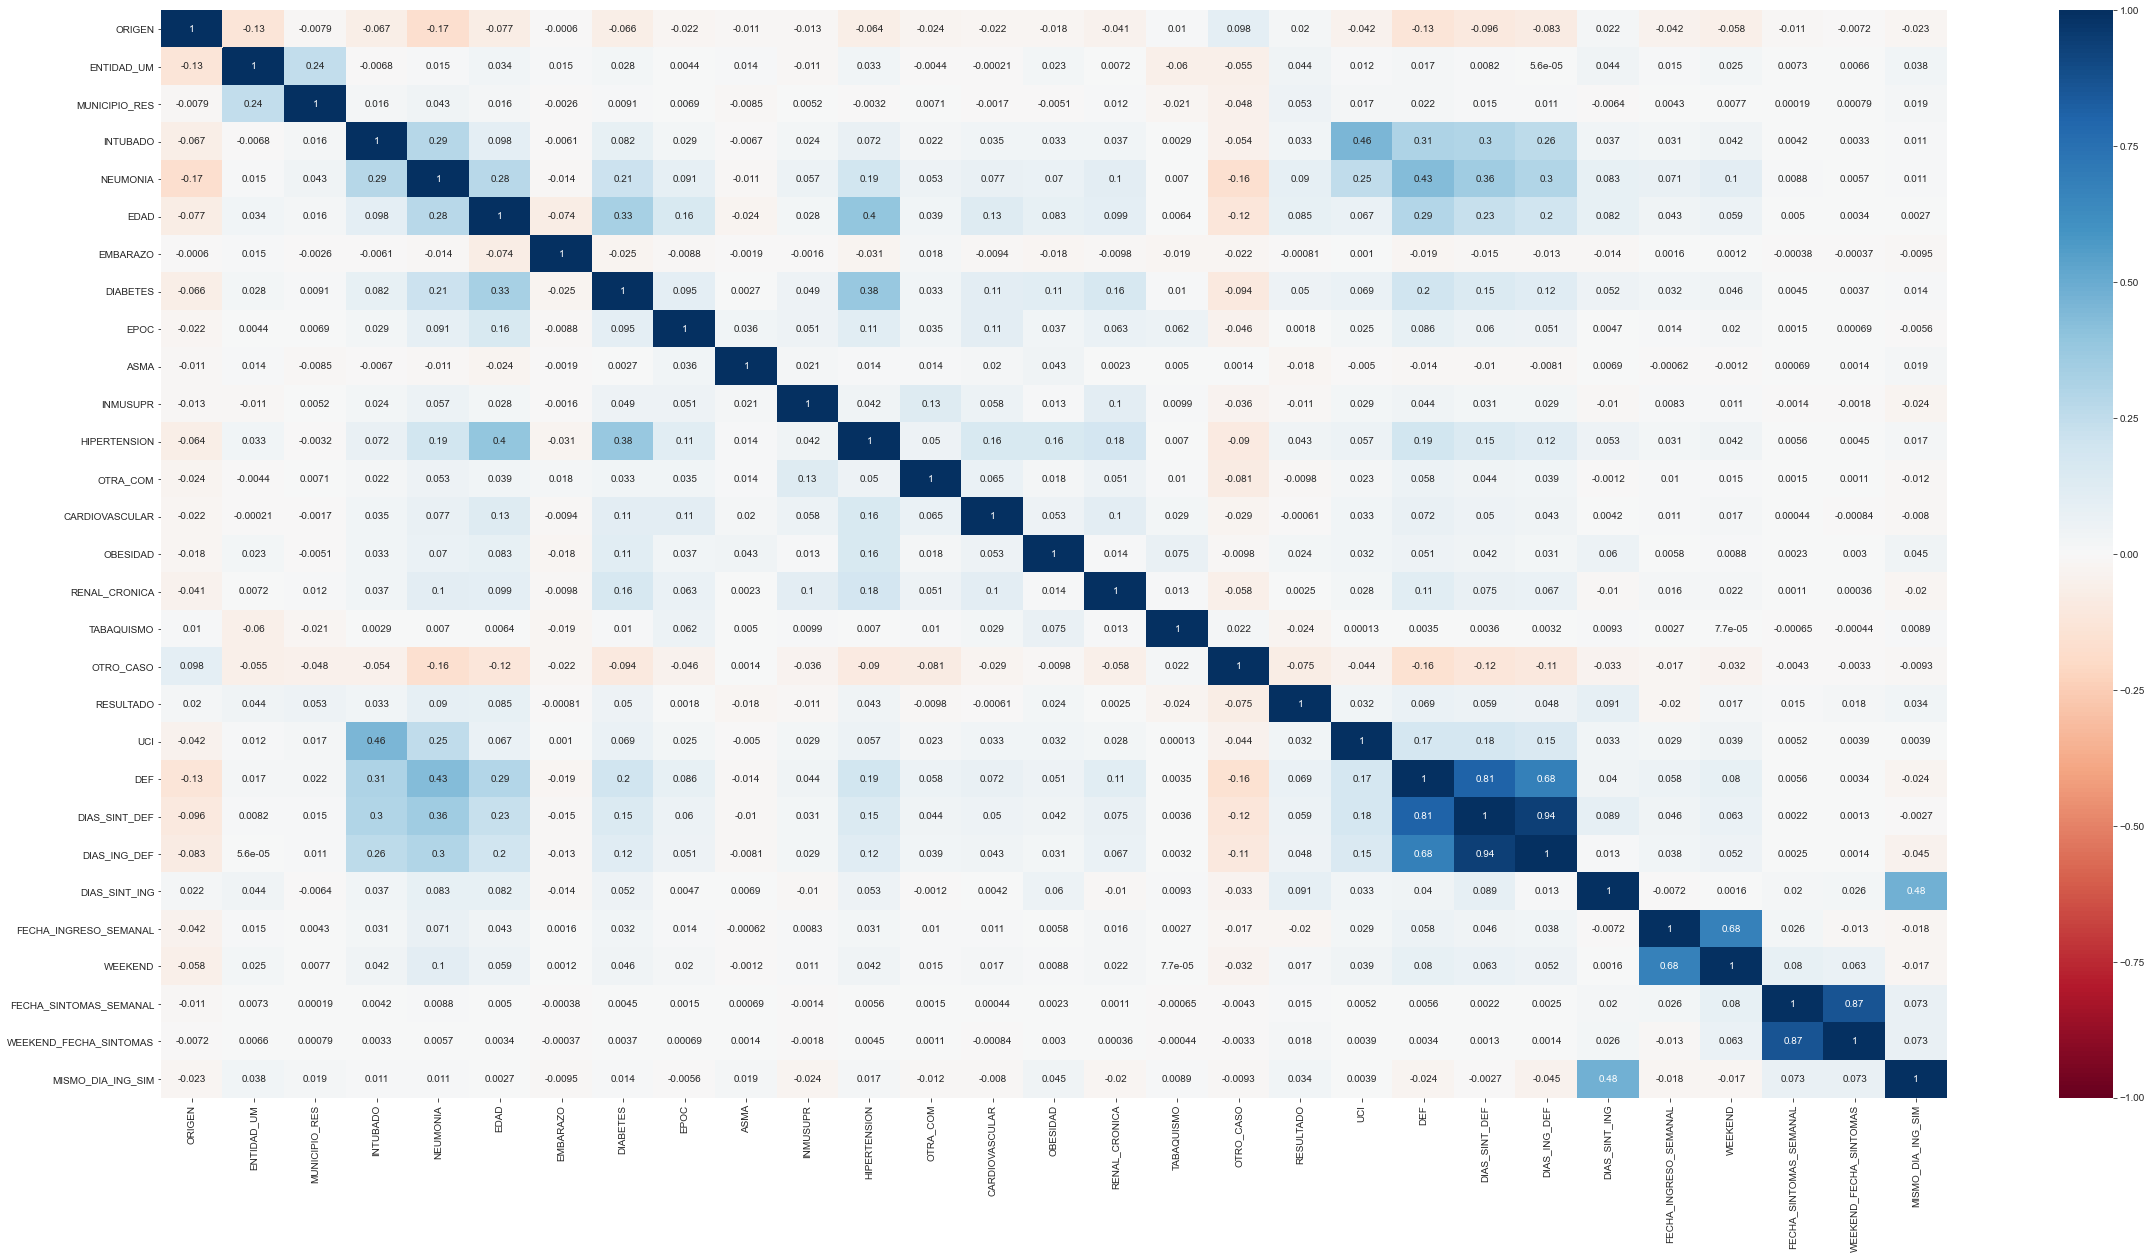

In [41]:
correlation = df_general.corr()
plt.figure(figsize=(40, 20))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu")

In [42]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127115 entries, 0 to 1127114
Data columns (total 40 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   FECHA_ACTUALIZACION     1127115 non-null  object        
 1   ID_REGISTRO             1127115 non-null  object        
 2   ORIGEN                  1127115 non-null  int64         
 3   SECTOR                  1127115 non-null  object        
 4   ENTIDAD_UM              1127115 non-null  int64         
 5   SEXO                    1127115 non-null  object        
 6   MUNICIPIO_RES           1127115 non-null  int64         
 7   TIPO_PACIENTE           1127115 non-null  object        
 8   FECHA_INGRESO           1127115 non-null  datetime64[ns]
 9   FECHA_SINTOMAS          1127115 non-null  datetime64[ns]
 10  FECHA_DEF               70062 non-null    datetime64[ns]
 11  INTUBADO                1127115 non-null  int64         
 12  NEUMONIA      

In [144]:
df_clea_data = df_general.to_csv(path + 'clean_data.csv',index=False)

## Exploratory Data Analysis 

### States with more COVID-19 tests



The figure below shows percentage of COVID-19 tests done in Mexico broken by state. Mexico city is the federal entity with the most number of tests. In second place is Mexico (the state). 

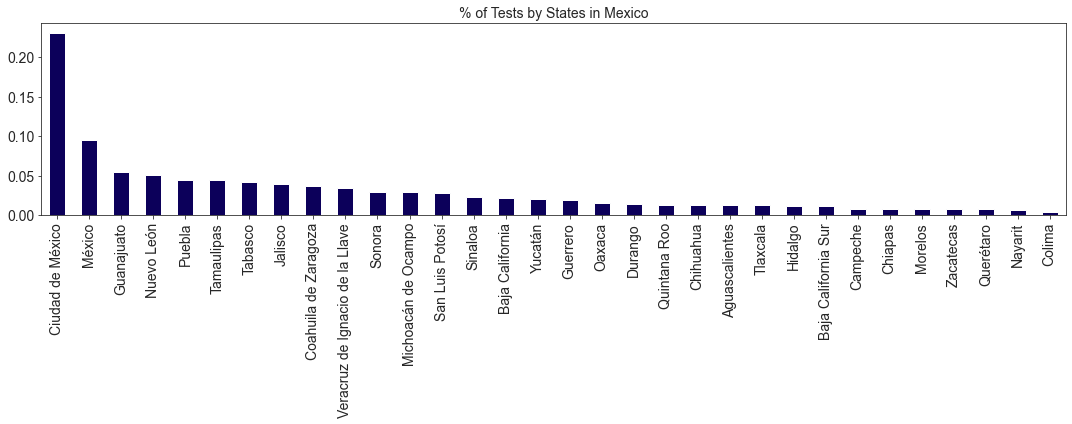

In [44]:
#plt.style.use('classic')
title_chart = '% of Tests by States in Mexico'
states_vals = df_general.ENTIDAD_NAME.value_counts()
#sns.set(palette="Blues_d")
sns.set_style("ticks")
fig = plt.figure(figsize=(15,6))
(states_vals/df_general.shape[0]).plot(kind="bar", color = '#0c005a', label='State');
plt.title(title_chart, fontsize = 14);
#plt.legend(prop={'size': 14})
plt.tick_params(labelsize=14) 
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [45]:
states_vals #/df_general.shape[0]

Ciudad de México                   260543
México                             107302
Guanajuato                          61846
Nuevo León                          56893
Puebla                              50777
Tamaulipas                          49589
Tabasco                             47155
Jalisco                             45103
Coahuila de Zaragoza                42149
Veracruz de Ignacio de la Llave     38271
Sonora                              33332
Michoacán de Ocampo                 32416
San Luis Potosí                     31410
Sinaloa                             25553
Baja California                     24238
Yucatán                             23491
Guerrero                            21794
Oaxaca                              17481
Durango                             15767
Quintana Roo                        14935
Chihuahua                           14751
Aguascalientes                      14276
Tlaxcala                            13844
Hidalgo                           

In [46]:
states_vals.sum()

1127115

In [47]:
states_vals.sum()/ df_gender_pop.Total.sum() * 100

0.8741882677398505

In [48]:
df_states_by_result = df_general.copy()
indexPendintResult = df_states_by_result[ df_states_by_result['RESULTADO'] == 3 ].index
df_states_by_result.drop(indexPendintResult , inplace=True)
df_states_by_result['RESULTADO'].replace(to_replace=[1,0], value=['POSITIVO','NO POSITIVO'],inplace=True)

In [49]:
pd.crosstab(df_states_by_result.FECHA_ACTUALIZACION, df_states_by_result.RESULTADO)

RESULTADO,NO POSITIVO,POSITIVO
FECHA_ACTUALIZACION,,
2020-08-12,545262,498380


In [50]:
df_state_results = pd.crosstab(df_states_by_result.ENTIDAD, df_states_by_result.RESULTADO, normalize=True)

In [51]:
df_state_results = df_state_results.reset_index()

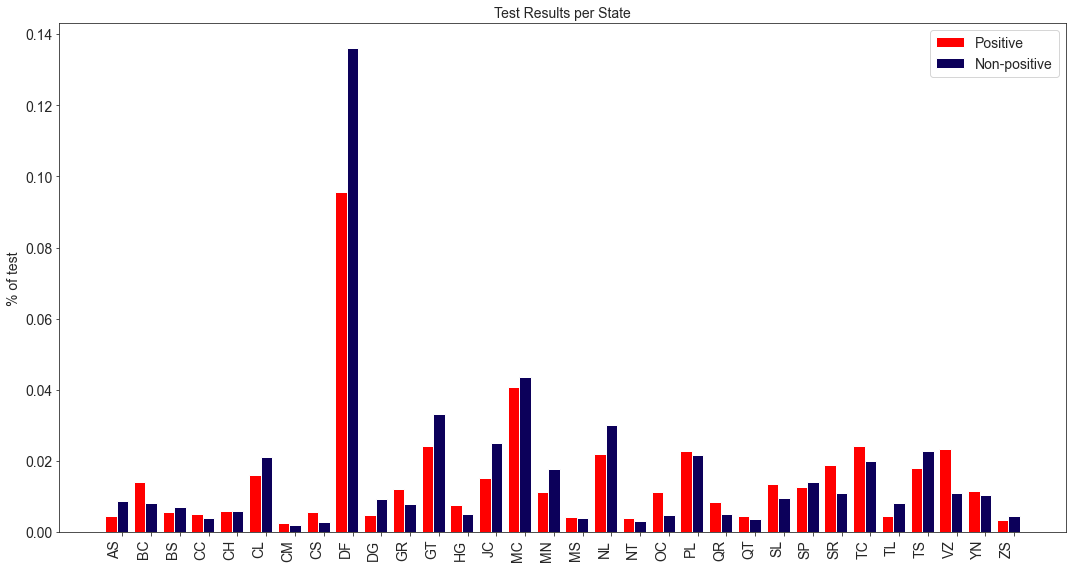

In [52]:
title_chart = 'Test Results per State'
width = 0.40
x = np.arange(len(df_state_results.ENTIDAD))
fig, ax = plt.subplots(figsize=(15, 8))


rects1 = ax.bar(x - width/2, df_state_results.POSITIVO, width, label='Positive', color = '#ff0000')
rects2 = ax.bar(x + width/2, df_state_results['NO POSITIVO'], width, label='Non-positive', color = '#0c005a')

ax.set_ylabel('% of test', fontsize = 14)
ax.set_title(title_chart, fontsize = 14)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_state_results.ENTIDAD, rotation=90, ha='right')
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14) 
fig.tight_layout()



plt.savefig('images/' + title_chart + '.png')
plt.show()

The graph shows the results of the tests done by federal entity. The results in the graphs have been normalized.

## Values  per Capita

In [53]:
df_states_key_vals = df_general.ENTIDAD_UM.value_counts().to_frame()
df_states_key_vals = df_states_key_vals.reset_index()
df_states_key_vals.rename(columns={df_states_key_vals.columns[0]: 'abbr' ,
                                   'ENTIDAD_UM':  'TESTS'}, inplace = True)

In [54]:
df_population = pd.merge(df_population, df_states_key_vals, left_on='Num', right_on='abbr')

In [55]:
df_population['PER_CAPITA'] = df_population['TESTS'] / df_population['Total'] * 100000

In [56]:
df_population['TESTS'].sum() / df_population['Total'].sum() * 100000

1003.3378454301308

In [57]:
df_population['abbr'] = df_population['abbr'].map(df_states.set_index('CLAVE_ENTIDAD')['ABREVIATURA'])

In [58]:
df_population.sort_values('Total', ascending=False).head()

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA
14,15,México,15175862.0,7396986.0,7778876.0,MC,107302,707.057036
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,260543,2943.629478
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,38271,500.719987
13,14,Jalisco,7350682.0,3600641.0,3750041.0,JC,45103,613.589324
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,50777,878.520801


In [59]:
df_population.sort_values('PER_CAPITA', ascending=False).head()

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,260543,2943.629478
2,3,Baja California Sur,637026.0,325433.0,311593.0,BS,13547,2126.600798
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,47155,2106.447637
4,5,Coahuila de Zaragoza,2748391.0,1364197.0,1384194.0,CL,42149,1533.588198
27,28,Tamaulipas,3268554.0,1616201.0,1652353.0,TS,49589,1517.154069


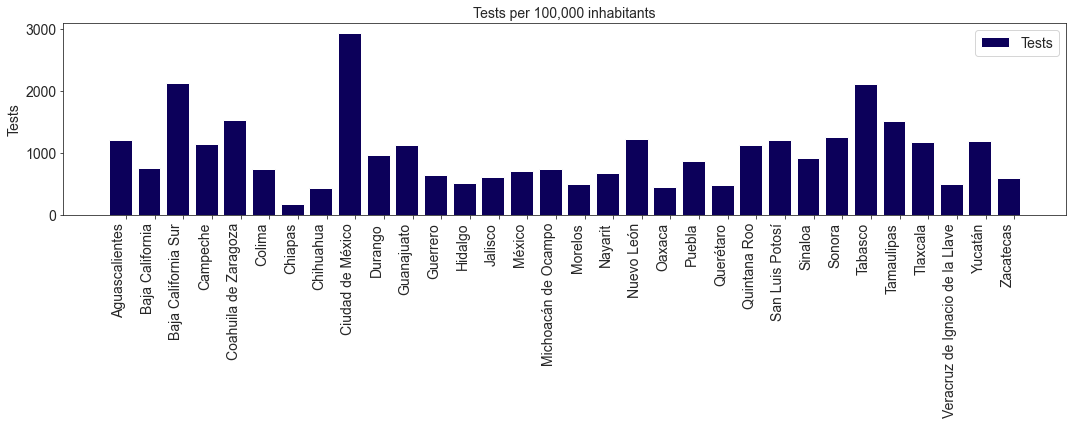

In [60]:
title_chart = 'Tests per 100,000 inhabitants'
width = 0.8 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x, df_population['PER_CAPITA'], width, label='Tests', color = '#0c005a')
ax.set_ylabel('Tests', fontsize = 14)
ax.set_title(title_chart, fontsize = 14)
ax.set_xticks(x + width/4 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14)
fig.tight_layout()

plt.savefig('images/' + title_chart + '.png')
plt.show()

### Positive cases per 100,000 inhabitants

In [61]:
df_result_tests = df_states_by_result.groupby(['ENTIDAD_UM', 'RESULTADO']).size().unstack()

In [62]:
df_result_tests = df_result_tests.reset_index()

In [63]:
df_population = pd.merge(df_population, df_result_tests, left_on='Num', right_on='ENTIDAD_UM')

In [64]:
# positive cases per capita
df_population['POS_PER_CAPITA'] = df_population['POSITIVO'] / df_population['Total'] * 100000

In [65]:
df_population.sort_values('POS_PER_CAPITA', ascending=False).head()

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,260543,2943.629478,9,142164,99756,1127.048903
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,47155,2106.447637,27,20923,25137,1122.887801
2,3,Baja California Sur,637026.0,325433.0,311593.0,BS,13547,2126.600798,3,7363,5784,907.969219
25,26,Sonora,2662480.0,1339612.0,1322868.0,SR,33332,1251.915507,26,11382,19609,736.493795
22,23,Quintana Roo,1325578.0,673220.0,652358.0,QR,14935,1126.678324,23,5363,8884,670.198208


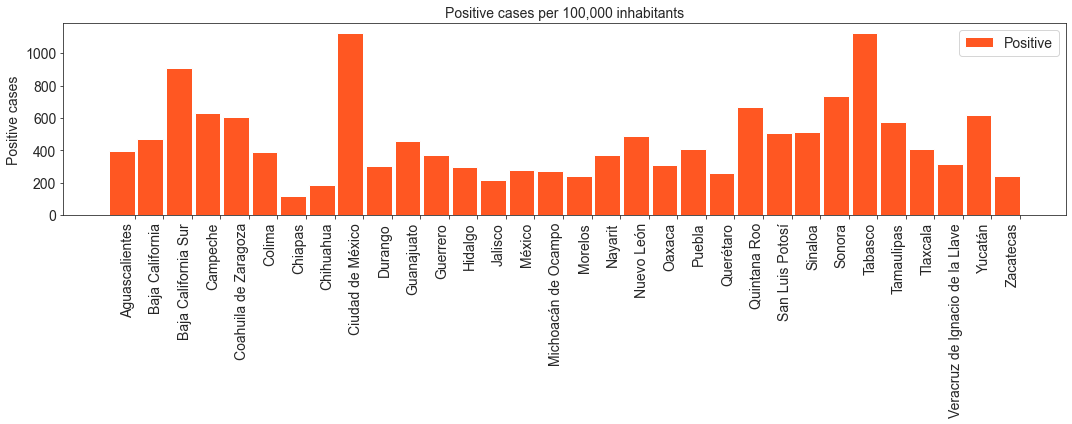

In [66]:
title_chart = 'Positive cases per 100,000 inhabitants'
width = 0.9 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x, df_population['POS_PER_CAPITA'], width, label='Positive', color = '#ff5722')

ax.set_ylabel('Positive cases',  fontsize = 14)
ax.set_title(title_chart, fontsize = 14)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right' , fontsize=14)
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14)
fig.tight_layout()

plt.savefig('images/' + title_chart + '.png')
plt.show()

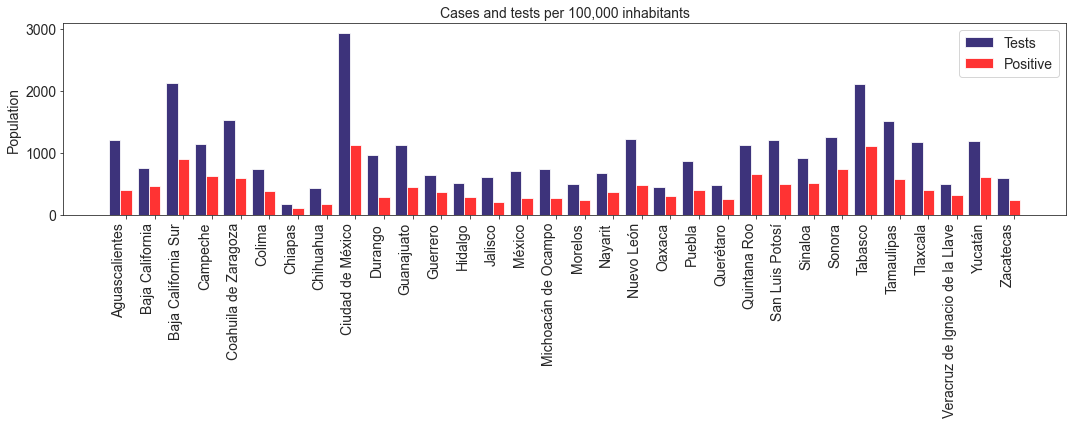

In [67]:
width = 0.4
title_chart = 'Cases and tests per 100,000 inhabitants' 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x - width/2, df_population['PER_CAPITA'], width, label='Tests', color = '#0c005a', alpha=0.8)
ax.bar(x + width/2, df_population['POS_PER_CAPITA'], width, label='Positive', color = '#ff0000', alpha=0.8)


ax.set_ylabel('Population', fontsize = 14)
ax.set_title(title_chart, fontsize = 14)
ax.set_xticks(x + width/2)
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14)
fig.tight_layout()

plt.savefig( 'images/' + title_chart + '.png')

plt.show()

In [68]:
df_population.sort_values('Total', ascending=False).head()

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA
14,15,México,15175862.0,7396986.0,7778876.0,MC,107302,707.057036,15,45626,42711,281.440356
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,260543,2943.629478,9,142164,99756,1127.048903
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,38271,500.719987,30,11598,24292,317.825244
13,14,Jalisco,7350682.0,3600641.0,3750041.0,JC,45103,613.589324,14,26056,15866,215.843918
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,50777,878.520801,21,22662,23743,410.790700


In [69]:
# positve cases normalized
df_population['POS_NOR'] = df_population.POSITIVO/ df_population.POSITIVO.sum()

In [70]:
df_population.sort_values('POS_NOR', ascending=False).head()

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA,POS_NOR
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,260543,2943.629478,9,142164,99756,1127.048903,0.200161
14,15,México,15175862.0,7396986.0,7778876.0,MC,107302,707.057036,15,45626,42711,281.440356,0.085700
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,61846,1127.265887,11,34617,25228,459.830285,0.050620
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,47155,2106.447637,27,20923,25137,1122.887801,0.050437
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,38271,500.719987,30,11598,24292,317.825244,0.048742


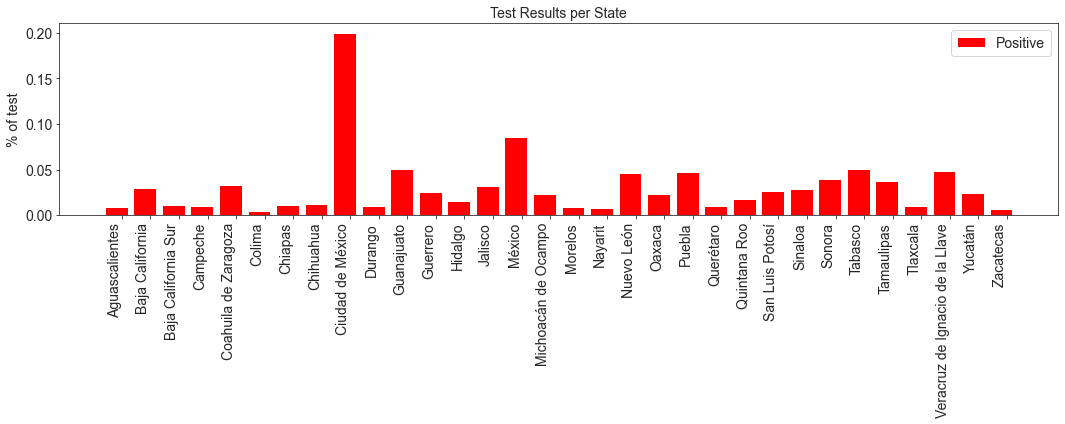

In [71]:
title_chart = 'Test Results per State'
width = 0.8
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 6))

rects1 = ax.bar(x, df_population.POS_NOR, width, label='Positive', color = '#ff0000')

ax.set_ylabel('% of test', fontsize = 14)
ax.set_title(title_chart, fontsize = 14)
ax.set_xticks(x + width/4)
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14)
fig.tight_layout()

plt.savefig('images/' + title_chart + '.png')
plt.show()

In [72]:
df_population.sort_values('POSITIVO', ascending=False).head()

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA,POS_NOR
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,260543,2943.629478,9,142164,99756,1127.048903,0.200161
14,15,México,15175862.0,7396986.0,7778876.0,MC,107302,707.057036,15,45626,42711,281.440356,0.085700
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,61846,1127.265887,11,34617,25228,459.830285,0.050620
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,47155,2106.447637,27,20923,25137,1122.887801,0.050437
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,38271,500.719987,30,11598,24292,317.825244,0.048742


In [73]:
df_population['Entidad'] = df_population[['Entidad', 'abbr']].agg(' '.join, axis=1)

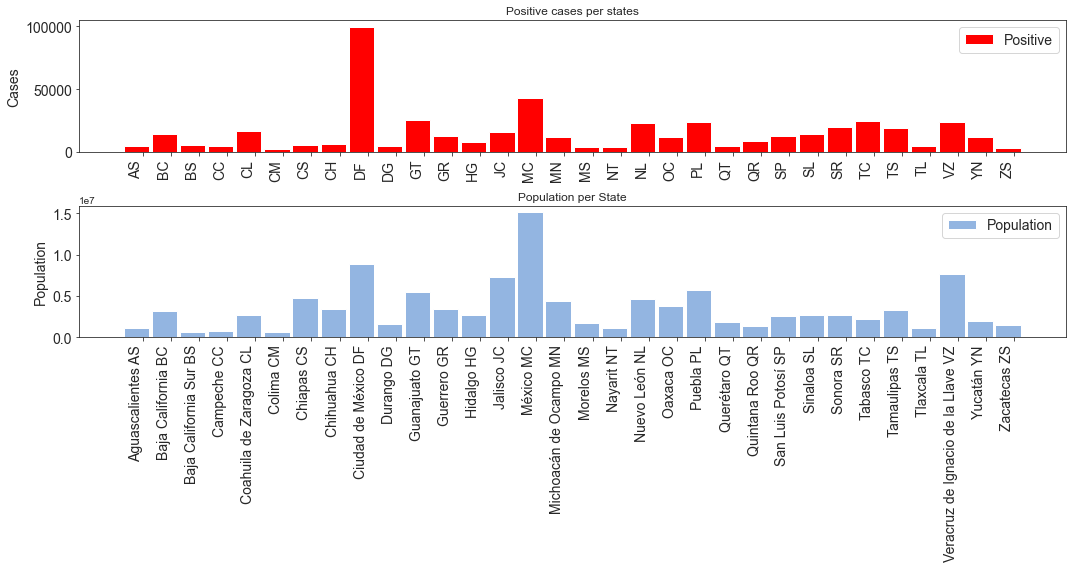

In [74]:
title_chart = 'Population and Positive cases per state'
width = 0.9 
fig, axs =plt.subplots(2,1, figsize=(15, 8))

axs[0].bar(x, df_population.POSITIVO, width, label='Positive', color = '#ff0000')

axs[0].set_title('Positive cases per states')
axs[0].set_ylabel('Cases', fontsize = 14)
axs[0].set_xticks(x + width/4)
axs[0].set_xticklabels(df_population.abbr, rotation=90, ha='right')
axs[0].legend(prop={'size': 14})
axs[0].tick_params(labelsize=14)

axs[1].bar(x, df_population.Total, width, label='Population', color = '#93b5e1')
axs[1].set_title('Population per State')
axs[1].set_ylabel('Population', fontsize = 14)
axs[1].set_xticks(x + width/4)
axs[1].set_xticklabels(df_population.Entidad, rotation=90, ha='right')
axs[1].legend(prop={'size': 14})
axs[1].tick_params(labelsize=14)

#fig.suptitle(title_chart, fontsize=20)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)
fig.tight_layout()
plt.savefig('images/' + title_chart + '.png')

###  Summary of Confimed/Deaths

In [75]:
df_positive = df_general[ df_general['RESULTADO'] == 1]
df_positive = df_positive[['FECHA_ACTUALIZACION','FECHA_INGRESO', 'FECHA_DEF', 'FECHA_SINTOMAS',
                           'RESULTADO', 'DEF', 'DIAS_SINT_ING', 'SEXO', 'EDAD', 'FECHA_INGRESO_SEMANAL', 
                           'WEEKEND', 'FECHA_SINTOMAS_SEMANAL','WEEKEND_FECHA_SINTOMAS', 'MISMO_DIA_ING_SIM']]

In [76]:
df_positive.rename({'EDAD': "Age"}, axis=1, inplace=True)

In [77]:
df_positive.DEF.sum()

54666

In [78]:
def bar_char (x_val, y_val, color_num, title_chart, y_axis_name, x_axis_name, i = False, figsize=(15,4) ):
    fig, ax = plt.subplots(figsize= figsize)
    x_pos = np.arange(len(x_val))

    ax.bar(x_pos, y_val, color=color_num)
    ax.set_ylabel(y_axis_name, fontsize = 14)
    ax.set_xlabel(x_axis_name, fontsize = 14)
    ax.set_title(title_chart, fontsize = 14)
    
    if i:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_val, rotation=90, ha='right')
        
    ax.legend(prop={'size': 14})
    ax.tick_params(labelsize=14)    
    plt.tight_layout()
    plt.savefig( 'images/' + title_chart + '.png')
    plt.show()
    


In [79]:
df_death_date = pd.crosstab(df_positive['FECHA_DEF'], df_positive.DEF)
df_death_date = df_death_date.reset_index()
df_death_date.rename({1: 'DEF'}, axis=1, inplace=True)

No handles with labels found to put in legend.


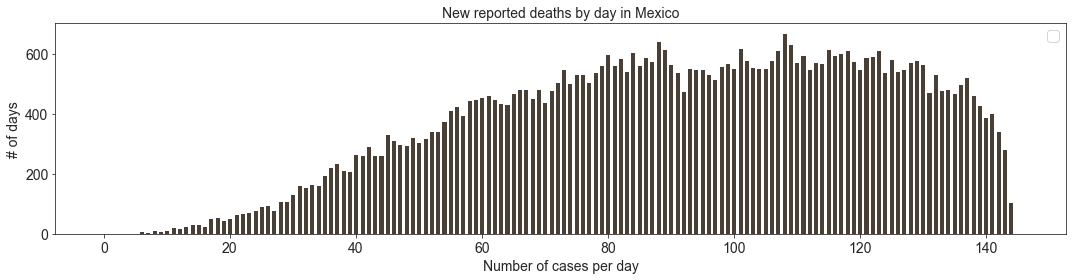

In [80]:
bar_char(df_death_date.FECHA_DEF, 
         df_death_date.DEF, 
         '#4a3f35', 
         'New reported deaths by day in Mexico', 
         '# of days',
         'Number of cases per day')

In [81]:
df_death_age = df_general[ df_general['DEF'] == 1]

In [82]:
df_death_age = df_death_age[['FECHA_ACTUALIZACION','FECHA_INGRESO', 'FECHA_DEF',
                           'RESULTADO', 'DEF', 'DIAS_SINT_ING', 'SEXO', 'EDAD']]

In [83]:
df_death_age.head()

,FECHA_ACTUALIZACION,FECHA_INGRESO,FECHA_DEF,RESULTADO,DEF,DIAS_SINT_ING,SEXO,EDAD
1,2020-08-12,2020-06-07,2020-06-09,1,1,1,Men,67
5,2020-08-12,2020-05-20,2020-06-09,1,1,7,Women,52
15,2020-08-12,2020-04-14,2020-04-24,1,1,0,Women,50
22,2020-08-12,2020-04-27,2020-04-27,1,1,4,Men,61
23,2020-08-12,2020-04-30,2020-05-15,1,1,0,Men,66


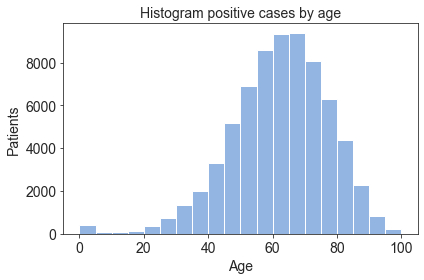

In [84]:
title_chart = 'Histogram positive cases by age'
fig= plt.figure(figsize=(6,4))

bins_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# create the histogram
(n, bins, patches) = plt.hist(df_death_age.EDAD, bins=bins_list,   label='hst', color = '#93b5e1')
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Patients',  size=14)
plt.title(title_chart,  size=14)

plt.tick_params(labelsize=14)
#plt.grid(True)
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [85]:
death_age_list = n
death_age_list= np.insert(death_age_list, 20,0)

In [86]:
len(death_age_list)

21

In [87]:
df_gender_pop['Deaths_Covid'] = death_age_list

In [88]:
df_gender_pop['Ratio_Deaths_Covid'] = df_gender_pop.Deaths_Covid/df_gender_pop.Total

In [89]:
df_gender_pop.head()

,Edad,M,F,Total,Deaths_Covid,Ratio_Deaths_Covid
0,0-4,5604781,5353961,10958742,403.0,0.000037
1,5-9,5731706,5478805,11210511,83.0,0.000007
2,10-14,5692822,5448048,11140870,106.0,0.000010
3,15-19,5695013,5514580,11209593,146.0,0.000013
4,20-24,5505161,5434658,10939819,372.0,0.000034


No handles with labels found to put in legend.


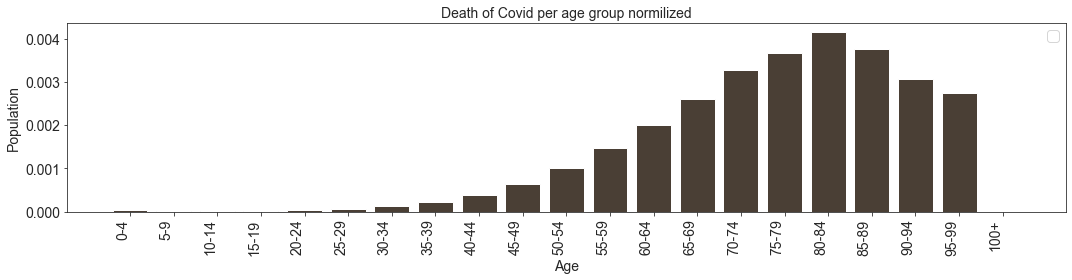

In [90]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Ratio_Deaths_Covid, 
         '#4a3f35', 
         'Death of Covid per age group normilized', 
         'Population',
         'Age',
          True)

In [91]:
df_dying  = df_general[(df_general['RESULTADO'] == 1 ) & (df_general['DEF'] == 1 )]
df_dying = df_dying[['FECHA_DEF','DIAS_SINT_DEF', 'FECHA_INGRESO_SEMANAL', 'SEXO']]
df_dying.set_index('FECHA_DEF', inplace=True)
df_dying.index = pd.to_datetime(df_dying.index)

No handles with labels found to put in legend.


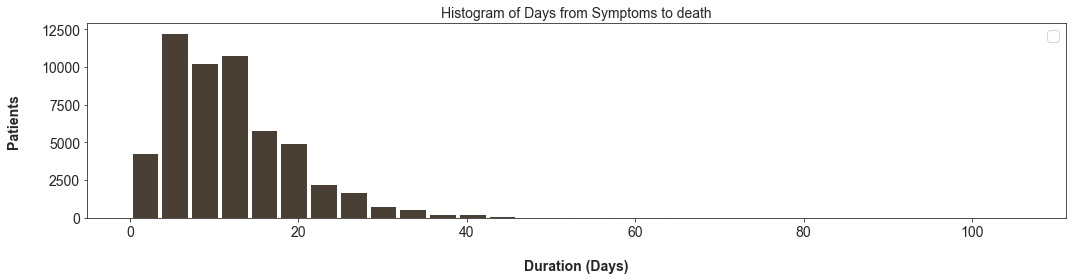

In [92]:
title_chart = 'Histogram of Days from Symptoms to death'
ax = df_dying.hist(column='DIAS_SINT_DEF', bins=30, grid=False, figsize=(15,4), color='#4a3f35',  rwidth=0.9)

for x in ax[0]:
    x.set_title(title_chart, fontsize = 14)
    x.set_xlabel('Duration (Days)', labelpad=20, weight='bold', size=14)
    x.set_ylabel('Patients', labelpad=20, weight='bold', size=14)
    x.tick_params(labelsize=14) 
    x.legend(prop={'size': 14})

plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')

In [93]:
outlier = df_dying[df_dying['DIAS_SINT_DEF']>30].count()
outlier

DIAS_SINT_DEF            1733
FECHA_INGRESO_SEMANAL    1733
SEXO                     1733
dtype: int64

The avergare number of days for a patient with COVID19 to dies is almost 12. There are cases that takes up to more than 3 months.


In [94]:
df_dying.describe()

,DIAS_SINT_DEF,FECHA_INGRESO_SEMANAL
count,54666.000000,54666.000000
mean,12.299126,2.859895
std,8.141696,1.989352
min,0.000000,0.000000
25%,7.000000,1.000000
50%,11.000000,3.000000
75%,16.000000,5.000000
max,106.000000,6.000000


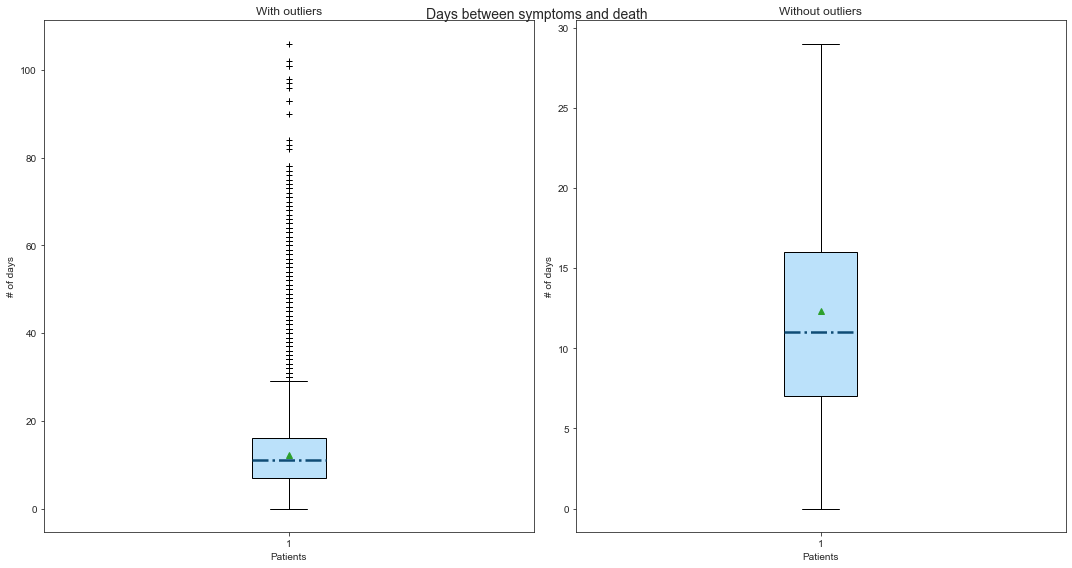

In [95]:
title_chart = 'Days between symptoms and death'
fig, axs =plt.subplots(1,2, figsize=(15, 8))
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#0f4c75')

axs[0].boxplot(df_dying['DIAS_SINT_DEF'],notch=0, sym='+', vert=1, whis=1.5,  patch_artist=True, 
               medianprops=medianprops, boxprops=dict(facecolor='#bbe1fa'),showmeans=True )
axs[0].set_title('With outliers')
axs[0].set_ylabel('# of days')
axs[0].set_xlabel('Patients')

axs[1].boxplot(df_dying['DIAS_SINT_DEF'], 0, '', patch_artist=True, 
               boxprops=dict(facecolor='#bbe1fa'), showmeans=True, medianprops=medianprops)
axs[1].set_title("Without outliers")
axs[1].set_ylabel('# of days')
axs[1].set_xlabel('Patients')

fig.suptitle(title_chart, fontsize=14)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)

plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')

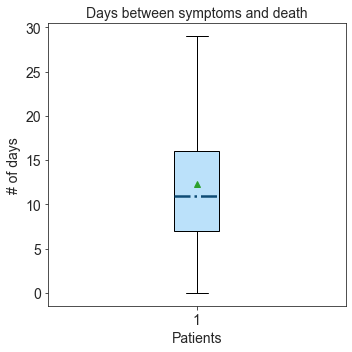

In [96]:
title_chart = 'Days between symptoms and death'
fig, axs =plt.subplots(figsize=(5,5))
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#0f4c75')

axs.boxplot(df_dying['DIAS_SINT_DEF'], 0, '', patch_artist=True, 
               boxprops=dict(facecolor='#bbe1fa'), showmeans=True, medianprops=medianprops)
axs.set_title(title_chart, fontsize = 14)
axs.set_ylabel('# of days', fontsize = 14)
axs.set_xlabel('Patients', fontsize = 14)

#axs.legend(prop={'size': 14})
axs.tick_params(labelsize=14) 

#fig.suptitle(title_chart, fontsize=20)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)

plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')

The boxplots show the distribution between number of days from first symptoms to death. The first boxplot includes outlier. In the second boxplot the outliers are removed.

### Confirmed Positive COVID-19 cases

In [97]:
df_gender_pop = df_gender_pop.dropna()


In [98]:
df_gender_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Edad                21 non-null     object 
 1   M                   21 non-null     int64  
 2   F                   21 non-null     int64  
 3   Total               21 non-null     int64  
 4   Deaths_Covid        21 non-null     float64
 5   Ratio_Deaths_Covid  21 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.1+ KB


In [99]:
gender_vals = list(df_positive.SEXO.value_counts(normalize=True))

In [100]:
gender_vals

[0.5288534852923472, 0.4711465147076528]

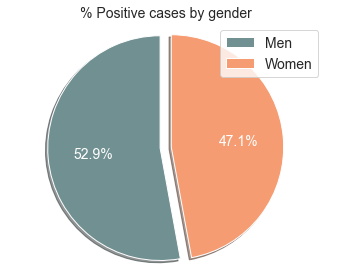

In [101]:
title_chart = '% Positive cases by gender'
labels ='Men', 'Women',
sizes = gender_vals
cs = ['#719092', '#F59C72']
#cs = ['#02383c', '#ed5107']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(5, 4))

wedges, texts, autotexts =  ax.pie(sizes, colors= cs, explode=explode, labels=labels, autopct='%1.1f%%',
                                   shadow=True, startangle=90, textprops={'fontsize': 14, 'color':"w"})

ax.set_title(title_chart, fontsize = 14)
ax.legend(wedges, labels,
          title="Gender",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14) 

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [102]:
# Percentage population by gender
pop_gender_nor_list = list()
pop_gender_nor_list.append(df_gender_pop.M.sum()/df_gender_pop.Total.sum())
pop_gender_nor_list.append(df_gender_pop.F.sum()/df_gender_pop.Total.sum())
pop_gender_nor_list

[0.48918125559608583, 0.5108187444039142]

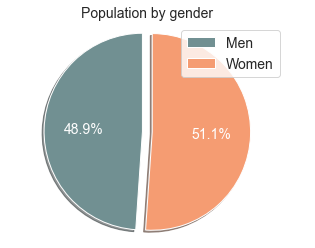

In [103]:
title_chart = 'Population by gender'
labels ='Men', 'Women',
sizes = pop_gender_nor_list
cs = ['#719092', '#F59C72']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(5, 4))

wedges, texts, autotexts =  ax.pie(sizes, colors= cs, explode=explode, labels=labels, autopct='%1.1f%%',
                                   shadow=True, startangle=90, textprops={'fontsize': 14, 'color':"w"})

ax.set_title(title_chart, fontsize = 14)
ax.legend(wedges, labels,
          title="Gender",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14) 


plt.savefig('images/' + title_chart + '.png')
plt.show()

In [104]:
pop_gender_list = list()
pop_gender_list.append(df_gender_pop.M.sum())
pop_gender_list.append(df_gender_pop.F.sum())

In [105]:
gender_values = list(df_positive.SEXO.value_counts())
gender = ['men','women']

In [106]:
dict = {'gender': gender, 'Covid': gender_values, 'Population': pop_gender_list}  
    
df_total_gender = pd.DataFrame(dict) 

In [107]:
df_total_gender['Ratio_Covid_Total'] = df_total_gender.Covid/df_total_gender.Population
df_total_gender

,gender,Covid,Population,Ratio_Covid_Total
0,men,263570,63071486,0.004179
1,women,234810,65861267,0.003565


No handles with labels found to put in legend.


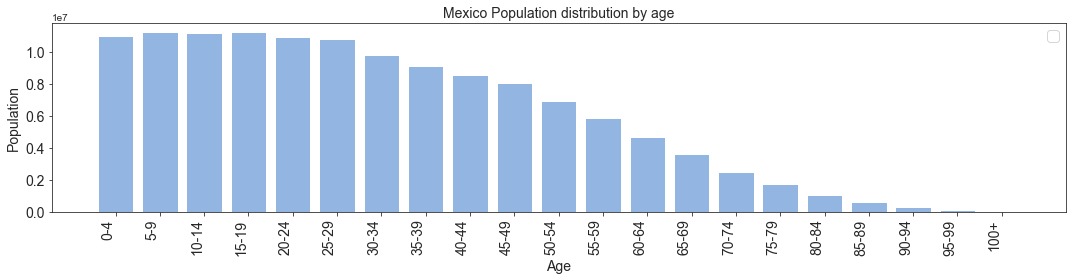

In [108]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Total,
         '#93b5e1', 
         'Mexico Population distribution by age', 
         'Population',
         'Age',
          True)

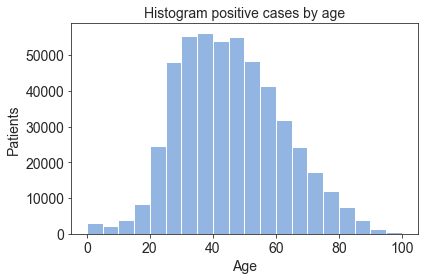

In [109]:
title_chart = 'Histogram positive cases by age'
fig= plt.figure(figsize=(6,4))

bins_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# create the histogram
(n, bins, patches) = plt.hist(df_positive.Age, bins=bins_list,   label='hst', color = '#93b5e1')
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Patients',  size=14)
plt.title(title_chart,  size=14)

#plt.legend(prop={'size': 14})
plt.tick_params(labelsize=14) 

plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [110]:
covid_age_list = n

In [111]:
# Add the last element to match the size of dataframe gender population
covid_age_list= np.insert(covid_age_list, 20,0)

In [112]:
len(covid_age_list) 

21

In [113]:
df_gender_pop['Cases_Covid'] = covid_age_list

In [114]:
df_gender_pop['Ratio_Covid_Total'] = df_gender_pop.Cases_Covid/df_gender_pop.Total

In [115]:
df_gender_pop.head()

,Edad,M,F,Total,Deaths_Covid,Ratio_Deaths_Covid,Cases_Covid,Ratio_Covid_Total
0,0-4,5604781,5353961,10958742,403.0,0.000037,2923.0,0.000267
1,5-9,5731706,5478805,11210511,83.0,0.000007,2254.0,0.000201
2,10-14,5692822,5448048,11140870,106.0,0.000010,3729.0,0.000335
3,15-19,5695013,5514580,11209593,146.0,0.000013,8313.0,0.000742
4,20-24,5505161,5434658,10939819,372.0,0.000034,24520.0,0.002241


No handles with labels found to put in legend.


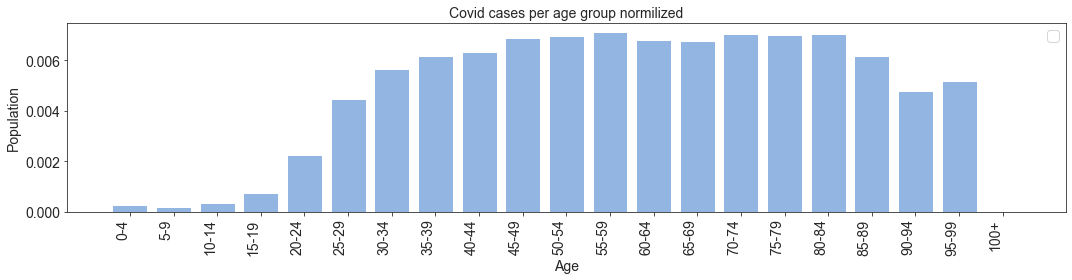

In [116]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Ratio_Covid_Total,
         '#93b5e1', 
         'Covid cases per age group normilized', 
         'Population',
         'Age',
          True)

In [117]:
df_age_women = df_positive[df_positive.SEXO == 'Women']
df_age_men = df_positive[df_positive.SEXO == 'Men']
age_women = list(df_age_women['Age'])
age_men = list(df_age_men['Age'])

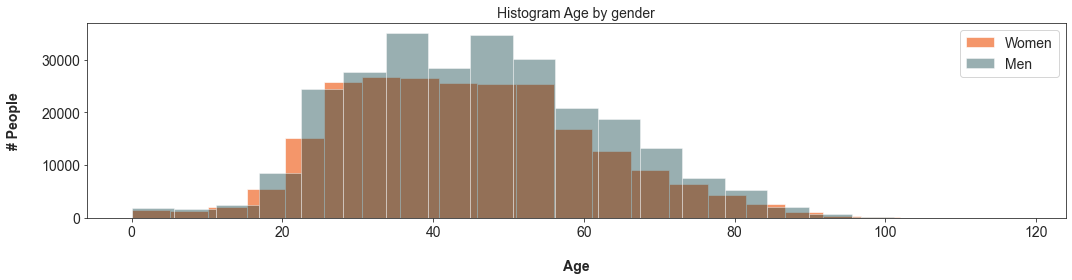

In [118]:
title_chart = 'Histogram Age by gender'
fig, ax =plt.subplots(figsize=(15, 4))

bins = 21 
ax.hist(age_women, bins, alpha=0.6, label='Women', color='#ed5107' )
ax.hist(age_men, bins, alpha=0.4, label='Men', color='#02383c')
ax.legend()
ax.set_title(title_chart, fontsize = 14)
ax.set_xlabel("Age", labelpad=20, weight='bold', size=14)
ax.set_ylabel("# People", labelpad=20, weight='bold', size=14)
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14) 
fig.tight_layout()


plt.savefig('images/' + title_chart + '.png')
plt.show()

Histogram of age broken by gender. 

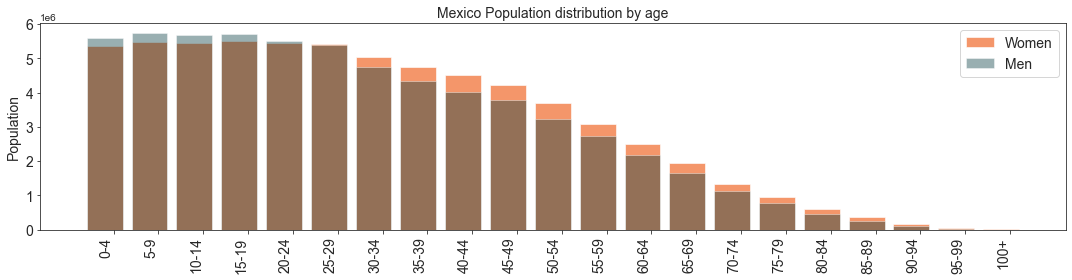

In [119]:
width = 0.8
title_chart = 'Mexico Population distribution by age' 
x = np.arange(len(df_gender_pop.Edad))
fig, ax = plt.subplots(figsize=(15, 4))

ax.bar(x, df_gender_pop.F, width, label='Women', color = '#ed5107', alpha=0.6)
ax.bar(x, df_gender_pop.M, width, label='Men', color = '#02383c', alpha=0.4)

ax.set_ylabel('Population', fontsize = 14)
ax.set_title(title_chart, fontsize = 14)
ax.set_xticks(x + width/4)
ax.set_xticklabels(df_gender_pop.Edad, rotation=90, ha='right')
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14) 
fig.tight_layout()

plt.savefig( 'images/' + title_chart + '.png')

plt.show()

In [120]:
df_hosp = df_positive[['FECHA_INGRESO', 'DIAS_SINT_ING']]
print ('Average number of days between first symptoms to hospitalization : ' + str(df_hosp.DIAS_SINT_ING.mean()))

Average number of days between first symptoms to hospitalization : 4.302213170672981


In [121]:
df_positive_results = pd.crosstab(df_positive['FECHA_INGRESO'], df_positive.RESULTADO)
df_positive_results = df_positive_results.reset_index()
df_positive_results.rename({1: 'POSITIVO'}, axis=1, inplace=True)

In [122]:
df_positive_results.POSITIVO.sum()

498380

No handles with labels found to put in legend.


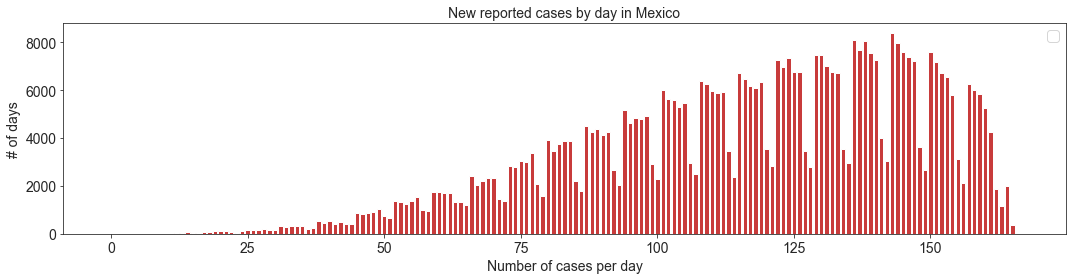

In [123]:
bar_char(df_positive_results.FECHA_INGRESO, 
         df_positive_results.POSITIVO,
         '#c83b3b', 
         'New reported cases by day in Mexico',
         '# of days',
         'Number of cases per day' )

The graph show a sharp decline every 6th and 7th day.

In [124]:
df_positive.head()

,FECHA_ACTUALIZACION,FECHA_INGRESO,FECHA_DEF,FECHA_SINTOMAS,RESULTADO,DEF,DIAS_SINT_ING,SEXO,Age,FECHA_INGRESO_SEMANAL,WEEKEND,FECHA_SINTOMAS_SEMANAL,WEEKEND_FECHA_SINTOMAS,MISMO_DIA_ING_SIM
0,2020-08-12,2020-05-27,NaT,2020-05-25,1,0,2,Men,54,2,0,0,0,True
1,2020-08-12,2020-06-07,2020-06-09,2020-06-06,1,1,1,Men,67,6,1,5,1,True
2,2020-08-12,2020-06-18,NaT,2020-06-08,1,0,10,Men,31,3,0,0,0,True
3,2020-08-12,2020-04-08,NaT,2020-04-02,1,0,6,Men,34,2,0,3,0,True
4,2020-08-12,2020-04-20,NaT,2020-04-17,1,0,3,Men,31,0,0,4,1,True


In [125]:
df_week = df_general[['FECHA_INGRESO_SEMANAL', 'WEEKEND', 'FECHA_SINTOMAS_SEMANAL','WEEKEND_FECHA_SINTOMAS',
                         'FECHA_INGRESO', 'FECHA_SINTOMAS','MISMO_DIA_ING_SIM']]

In [126]:
df_week_ingreso = df_week.FECHA_INGRESO_SEMANAL.value_counts().to_frame()
df_week_ingreso = df_week_ingreso.reset_index()
df_week_ingreso.rename(columns={df_week_ingreso.columns[0]: 'Day' ,
                                   'FECHA_INGRESO_SEMANAL':  'INGRESO_SEMANAL'}, inplace = True)

In [127]:
df_week_ingreso['INGRESO_SEMANAL_NORMALIZE'] = df_week_ingreso['INGRESO_SEMANAL']/ df_week_ingreso.INGRESO_SEMANAL.sum()

In [128]:
df_week_ingreso

,Day,INGRESO_SEMANAL,INGRESO_SEMANAL_NORMALIZE
0,0,204941,0.181828
1,1,198792,0.176372
2,2,188990,0.167676
3,4,185739,0.164792
4,3,184329,0.163541
5,5,94438,0.083787
6,6,69886,0.062004


In [129]:
df_week_symptoms = df_week.FECHA_SINTOMAS_SEMANAL.value_counts().to_frame()
df_week_symptoms = df_week_symptoms.reset_index()
df_week_symptoms.rename(columns={df_week_symptoms.columns[0]: 'Day' ,
                                   'FECHA_SINTOMAS_SEMANAL':  'SINTOMAS_SEMANAL'}, inplace = True)

In [130]:
df_week_symptoms

,Day,SINTOMAS_SEMANAL
0,0,192666
1,4,170013
2,2,161143
3,5,156463
4,1,154514
5,3,148050
6,6,144266


In [131]:
df_week_symptoms['SINTOMAS_SEMANAL_NORMALIZE'] = df_week_symptoms['SINTOMAS_SEMANAL']/ df_week_symptoms.SINTOMAS_SEMANAL.sum()

In [132]:
df_week_symptoms_ingreso = pd.merge(df_week_ingreso, df_week_symptoms, left_on='Day', right_on='Day')

In [133]:
df_week_symptoms_ingreso

,Day,INGRESO_SEMANAL,INGRESO_SEMANAL_NORMALIZE,SINTOMAS_SEMANAL,SINTOMAS_SEMANAL_NORMALIZE
0,0,204941,0.181828,192666,0.170937
1,1,198792,0.176372,154514,0.137088
2,2,188990,0.167676,161143,0.142969
3,4,185739,0.164792,170013,0.150839
4,3,184329,0.163541,148050,0.131353
5,5,94438,0.083787,156463,0.138817
6,6,69886,0.062004,144266,0.127996


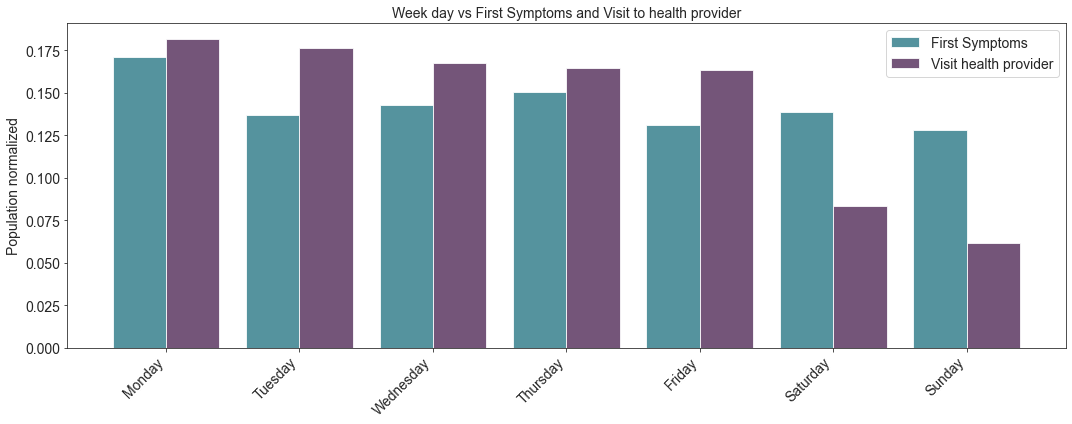

In [134]:
width = 0.4
title_chart = 'Week day vs First Symptoms and Visit to health provider' 
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
x = np.arange(len(week_days))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x - width/2, df_week_symptoms_ingreso.SINTOMAS_SEMANAL_NORMALIZE, width, label='First Symptoms', color = '#2a7886', alpha=0.8)
ax.bar(x + width/2, df_week_symptoms_ingreso.INGRESO_SEMANAL_NORMALIZE , width, label='Visit health provider', color = '#512b58', alpha=0.8)


ax.set_ylabel('Population normalized', fontsize = 14)
ax.set_title(title_chart, fontsize = 14)
ax.set_xticks(x )
ax.set_xticklabels(week_days, rotation=45, ha='right')
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=14)
fig.tight_layout()

plt.savefig( 'images/' + title_chart + '.png')

plt.show()

In [135]:
df_friday = df_week[df_week.FECHA_SINTOMAS_SEMANAL == 4]

In [136]:
df_friday.count()

FECHA_INGRESO_SEMANAL     170013
WEEKEND                   170013
FECHA_SINTOMAS_SEMANAL    170013
WEEKEND_FECHA_SINTOMAS    170013
FECHA_INGRESO             170013
FECHA_SINTOMAS            170013
MISMO_DIA_ING_SIM         170013
dtype: int64

In [137]:
df_friday.FECHA_INGRESO_SEMANAL.value_counts()

4    41860
0    37186
1    28323
2    21991
3    14571
5    14514
6    11568
Name: FECHA_INGRESO_SEMANAL, dtype: int64

In [138]:
df_friday.MISMO_DIA_ING_SIM.value_counts()

True     141459
False     28554
Name: MISMO_DIA_ING_SIM, dtype: int64

In [139]:
41860 - 28554

13306

In [140]:
df_monday = df_week[df_week.FECHA_SINTOMAS_SEMANAL == 0]

In [141]:
df_monday.count()

FECHA_INGRESO_SEMANAL     192666
WEEKEND                   192666
FECHA_SINTOMAS_SEMANAL    192666
WEEKEND_FECHA_SINTOMAS    192666
FECHA_INGRESO             192666
FECHA_SINTOMAS            192666
MISMO_DIA_ING_SIM         192666
dtype: int64

In [142]:
df_monday.MISMO_DIA_ING_SIM.value_counts()

True     163319
False     29347
Name: MISMO_DIA_ING_SIM, dtype: int64

In [143]:
df_monday.FECHA_INGRESO_SEMANAL.value_counts()

0    46731
3    33573
1    33282
2    32274
4    28694
5    11626
6     6486
Name: FECHA_INGRESO_SEMANAL, dtype: int64